In [1]:
import ast
import pandas as pd
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report as seqeval_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import Dataset
import numpy as np
import torch



/home/labadmin/anaconda3/envs/sb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your dataset
df = pd.read_csv("/home/labadmin/SMT/ATE_bio_tagged_output.csv")
df['tokens'] = df['Word_Tokens'].apply(ast.literal_eval)
df['labels'] = df['BIO_Tags'].apply(ast.literal_eval)

In [3]:




# Build label mappings
label_list = sorted({label for sequence in df['labels'] for (_, label) in sequence})
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
df['label_ids'] = df['labels'].apply(lambda seq: [label2id[tag] for (_, tag) in seq][:128])

In [4]:

# print(dataset[0]['labels'])

# Map labels to IDs
def encode_labels(batch):
    return {
        'label_ids': [
            [label2id[tag] for (_, tag) in seq]
            for seq in batch['labels']
        ]
    }


# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df[['tokens', 'labels']])
# dataset = dataset.map(encode_labels)
dataset = dataset.map(encode_labels, batched=True)

Map: 100%|██████████| 5000/5000 [00:00<00:00, 17112.96 examples/s]


In [5]:




# Global tokenizer variable will be set in run_baseline
tokenizer = None

def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        truncation=True,
        padding='max_length',
        max_length=128,
        is_split_into_words=True,
    )

    word_ids = tokenized.word_ids()
    aligned_labels = []
    previous_word_id = None

    for i, word_id in enumerate(word_ids):
        if word_id is None:
            aligned_labels.append(-100)
        elif word_id != previous_word_id:
            aligned_labels.append(example["label_ids"][word_id])
        else:
            aligned_labels.append(example["label_ids"][word_id])
        previous_word_id = word_id

    tokenized["labels"] = aligned_labels
    return tokenized

In [6]:
# import torch
# print("CUDA available:", torch.cuda.is_available())
# print("CUDA version:", torch.version.cuda)
# print("Torch built with:", torch.__config__.show())


In [7]:
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AlbertTokenizer

def smart_tokenizer(model_name):
    if "indic-bert" in model_name.lower():
        return AlbertTokenizer.from_pretrained(model_name)
    return AutoTokenizer.from_pretrained(model_name, use_fast=True)


def run_baseline(model_name, baseline_name):
    global tokenizer
    print(f"\n🔍 Running: {baseline_name}")

    tokenizer = smart_tokenizer(model_name)


    # Shuffle & split
    df_shuffled = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    train_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)

    # Convert to HF Dataset
    train_dataset = Dataset.from_pandas(train_df[['tokens', 'labels']])
    test_dataset = Dataset.from_pandas(test_df[['tokens', 'labels']])

    train_dataset = train_dataset.map(encode_labels, batched=True)
    test_dataset = test_dataset.map(encode_labels, batched=True)

    def tokenize_and_align(ex):
        tokenized = tokenizer(
            ex["tokens"],
            truncation=True,
            padding='max_length',
            max_length=128,
            is_split_into_words=True,
        )

        labels = ex["label_ids"]
        # Pad/truncate labels to match input length
        aligned = labels[:128] + [-100] * (128 - len(labels))
        tokenized["labels"] = aligned
        return tokenized


    # Apply tokenization
    train_dataset = train_dataset.map(tokenize_and_align, batched=False, remove_columns=["tokens", "labels", "label_ids"])
    test_dataset = test_dataset.map(tokenize_and_align, batched=False, remove_columns=["tokens", "labels", "label_ids"])

    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id
    )

    from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

    # args = TrainingArguments(
    # output_dir="./results/your_model",
    # per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # num_train_epochs=50,
    # logging_dir="./logs",
    # evaluation_strategy="epoch",
    # save_strategy="epoch",
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    # greater_is_better=False,
    # save_total_limit=2,
    # report_to="none"
    # )

    # trainer = Trainer(
    # model=model,
    # args=args,
    # train_dataset=train_dataset,
    # eval_dataset=test_dataset,
    # tokenizer=tokenizer,
    # data_collator=DataCollatorForTokenClassification(tokenizer),
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    # )

    args = TrainingArguments(
    output_dir=f"./results/{baseline_name.replace(' ', '_')}",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    logging_dir="./logs"
)


    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
    )

    trainer.train()

    # Evaluate
    pred_logits = trainer.predict(test_dataset).predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    label_ids = test_dataset['labels']

    decoded_preds, decoded_labels = [], []
    for preds, labels in zip(pred_ids, label_ids):
        sentence_preds = []
        sentence_labels = []
        for p, l in zip(preds, labels):
            if l != -100:
                sentence_preds.append(id2label[p])
                sentence_labels.append(id2label[l])
        decoded_preds.append(sentence_preds)
        decoded_labels.append(sentence_labels)

    print(seqeval_report(decoded_labels, decoded_preds, digits=4, zero_division=0))




In [ ]:
# --- Run Baselines ---
run_baseline("bert-base-multilingual-cased", "mBERT Fine-Tuned")



🔍 Running: mBERT Fine-Tuned


Map: 100%|██████████| 1000/1000 [00:00<00:00, 5220.95 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1889397/475144546.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.352100
1000,0.330700
1500,0.318900
2000,0.314900
2500,0.322800
3000,0.316500
3500,0.319200
4000,0.309000
4500,0.304600
5000,0.298600


In [ ]:
run_baseline("ai4bharat/indic-bert", "IndicBERT Fine-Tuned")

In [ ]:
run_baseline("xlm-roberta-base", "XLM-R Fine-Tuned")

Label2ID: {'B-applications': 0, 'B-battery': 1, 'B-camera': 2, 'B-design': 3, 'B-display': 4, 'B-game': 5, 'B-general': 6, 'B-hardware': 7, 'B-laptop': 8, 'B-memory': 9, 'B-network': 10, 'B-os': 11, 'B-phone': 12, 'B-price': 13, 'B-processor': 14, 'B-screen': 15, 'B-software': 16, 'B-speaker': 17, 'B-tablet': 18, 'I-battery': 19, 'I-camera': 20, 'I-design': 21, 'I-display': 22, 'I-general': 23, 'I-hardware': 24, 'I-memory': 25, 'I-phone': 26, 'I-processor': 27, 'I-screen': 28, 'I-software': 29, 'I-speaker': 30, 'I-tablet': 31, 'O': 32}
Sample label_ids: [32, 12, 26, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

/home/labadmin/anaconda3/envs/sb/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

applications     0.8000    0.2500    0.3810        16
     battery     0.0000    0.0000    0.0000        23
      camera     0.7273    0.0874    0.1561       183
      design     0.4444    0.1026    0.1667        39
     general     0.0000    0.0000    0.0000         9
    hardware     0.0000    0.0000    0.0000         3
      laptop     0.0000    0.0000    0.0000         3
      memory     0.1250    0.0625    0.0833        16
     network     0.8571    0.1935    0.3158        31
          os     1.0000    0.0667    0.1250        15
       phone     0.7975    0.2490    0.3795       253
       price     0.0000    0.0000    0.0000        56
   processor     0.0000    0.0000    0.0000        13
      screen     0.0000    0.0000    0.0000        36
    software     0.0000    0.0000    0.0000        36
     speaker     0.0000    0.0000    0.0000         3
      tablet     0.0000    0.0000    0.0000         2

   micro avg     0.7252   

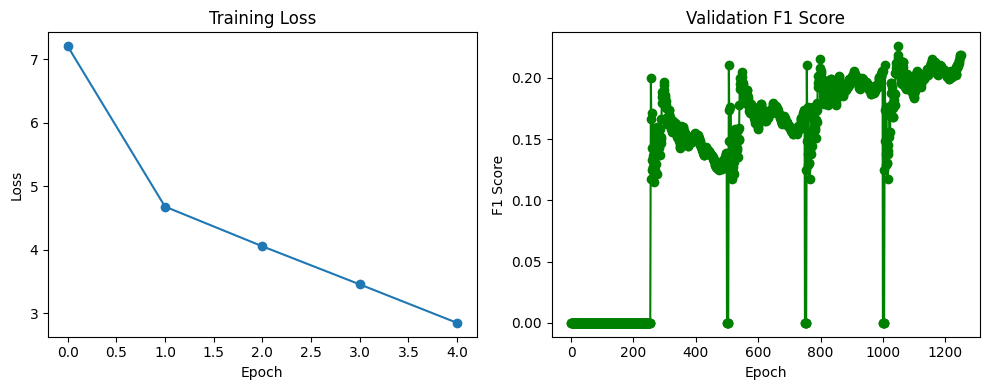

In [ ]:
from torchcrf import CRF
import torch.nn as nn
import torch.optim as optim
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report as seqeval_report, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

def tokenize_and_align_labels(tokens, labels):
    encoding = tokenizer(tokens, truncation=True, padding='max_length',
                         max_length=MAX_LEN, is_split_into_words=True, return_tensors='pt')
    word_ids = encoding.word_ids()
    aligned_labels = []
    label_idx = 0
    for word_id in word_ids:
        if word_id is None:
            aligned_labels.append(-100)  # ignore
        elif word_id != word_ids[label_idx - 1]:
            aligned_labels.append(label2id[labels[word_id][1]])
        else:
            aligned_labels.append(label2id[labels[word_id][1]])
    return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), aligned_labels

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
# Pad to fixed max length
MAX_LEN = 128
def encode_inputs(tokens):
    encoding = tokenizer(
        tokens,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        is_split_into_words=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)

def pad_labels(label_seq, pad_value=None, max_len=128):
    if pad_value is None:
        pad_value = label2id['O']
    tags = [tag for (_, tag) in label_seq]
    label_ids = [label2id[tag] for tag in tags][:max_len]
    return label_ids + [pad_value] * (max_len - len(label_ids))

df['label_ids'] = df['labels'].apply(pad_labels)



class ATECustomDataset(Dataset):
    def __init__(self, df):
        self.input_ids = []
        self.attention_masks = []
        self.labels = []
        for _, row in df.iterrows():
            input_id, mask = encode_inputs(row['tokens'])
            self.input_ids.append(input_id)
            self.attention_masks.append(mask)
            self.labels.append(torch.tensor(row['label_ids']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

from torch.nn.utils.rnn import pad_sequence

def bilstm_crf_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]

    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=label2id['O'])  # Use valid index!

    return {
        'input_ids': padded_input_ids,
        'labels': padded_labels
    }


def __getitem__(self, idx):
    return {
        "input_ids": self.input_ids[idx],
        "labels": self.labels[idx]
    }

# BiLSTM+CRF Model
class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256, pad_idx=0):
        super(BiLSTMCRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)  # 🔧 <-- Add this line
        
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, input_ids, labels=None, mask=None):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)



# Prepare data
df_shuffled = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)
train_dataset = ATECustomDataset(train_df)
test_dataset = ATECustomDataset(test_df)

from collections import Counter
from seqeval.metrics import classification_report as seqeval_report


from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=bilstm_crf_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=bilstm_crf_collate_fn)

print("Label2ID:", label2id)
print("Sample label_ids:", df['label_ids'].iloc[0])
print("Number of classes:", len(label_list))


# Initialize model
vocab_size = tokenizer.vocab_size
model = BiLSTMCRF(vocab_size, len(label_list), pad_idx=tokenizer.pad_token_id)

# model = BiLSTMCRF(len(tokenizer), len(label_list))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_f1s = []

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    # for batch in train_loader:
    #     optimizer.zero_grad()
    #     input_ids = batch['input_ids'].to(device)
    #     labels = batch['labels'].to(device)
    #     loss = model(input_ids, labels) 
    #     loss.backward()
    #     optimizer.step()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        # Create mask for CRF
        mask = (input_ids != tokenizer.pad_token_id).to(torch.bool)

        # CRF expects shape: (batch_size, seq_len)
        # Labels must be in range [0, num_labels-1], no -100
        loss = model(input_ids, labels, mask=mask)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            mask = (input_ids != tokenizer.pad_token_id).to(torch.bool)

            # Get predictions
            predictions = model(input_ids, mask=mask)  # shape: List[List[int]]


            for pred_seq, label_seq, m in zip(predictions, labels, mask):
                true_len = m.sum().item()
                all_preds.append([id2label[p] for p in pred_seq[:true_len]])
                all_labels.append([id2label[l.item()] for l in label_seq[:true_len]])
            
            
            epoch_f1 = f1_score(all_labels, all_preds)
            val_f1s.append(epoch_f1)

# Report
from seqeval.metrics import classification_report
print(classification_report(all_labels, all_preds, digits=4))


# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_f1s, marker='o', color='green')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torchcrf import CRF
from seqeval.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Config ---
MAX_LEN = 128
MODEL_NAME = "bert-base-multilingual-cased"
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- Label mappings ---
# label2id = {'B-applications': 0, 'B-battery': 1, 'B-camera': 2, 'B-design': 3, 'B-display': 4, 'B-game': 5,
#             'B-general': 6, 'B-hardware': 7, 'B-laptop': 8, 'B-memory': 9, 'B-network': 10, 'B-os': 11,
#             'B-phone': 12, 'B-price': 13, 'B-processor': 14, 'B-screen': 15, 'B-software': 16, 'B-speaker': 17,
#             'B-tablet': 18, 'I-battery': 19, 'I-camera': 20, 'I-design': 21, 'I-display': 22, 'I-general': 23,
#             'I-hardware': 24, 'I-memory': 25, 'I-phone': 26, 'I-processor': 27, 'I-screen': 28, 'I-software': 29,
#             'I-speaker': 30, 'I-tablet': 31, 'O': 32}
# id2label = {v: k for k, v in label2id.items()}
NUM_CLASSES =  len(label_list)

# --- Dataset ---
class ATEAlignedDataset(Dataset):
    def __init__(self, df):
        self.samples = []
        for _, row in df.iterrows():
            tokens = row['tokens']
            labels = [tag for (_, tag) in row['labels']]

            encoding = tokenizer(tokens, is_split_into_words=True,
                                 truncation=True, padding='max_length',
                                 max_length=MAX_LEN, return_tensors='pt')

            word_ids = encoding.word_ids(batch_index=0)
            label_ids = []
            previous_word_idx = None
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(label2id.get(labels[word_idx], label2id['O']))
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx

            self.samples.append({
                'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze(),
                'labels': torch.tensor(label_ids)
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# --- Model ---
class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1,
                            bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, input_ids, labels=None, mask=None):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        emissions = self.hidden2tag(x)

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)

# --- Collate ---
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# --- Load data ---
# Your dataframe: df (with columns 'tokens', 'labels')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = ATEAlignedDataset(train_df)
test_dataset = ATEAlignedDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# --- Train ---
model = BiLSTMCRF(vocab_size=tokenizer.vocab_size, tagset_size=NUM_CLASSES, pad_idx=tokenizer.pad_token_id).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        mask = (input_ids != tokenizer.pad_token_id).to(torch.bool)

        optimizer.zero_grad()
        loss = model(input_ids, labels=labels, mask=mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# --- Evaluate ---
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        mask = (input_ids != tokenizer.pad_token_id).to(torch.bool)
        predictions = model(input_ids, mask=mask)

        for pred_seq, label_seq, m in zip(predictions, labels, mask):
            true_len = m.sum().item()
            true_labels = [id2label[l.item()] for l in label_seq[:true_len] if l.item() != -100]
            pred_labels = [id2label[p] for p in pred_seq[:true_len]]
            all_labels.append(true_labels)
            all_preds.append(pred_labels)

print(classification_report(all_labels, all_preds, digits=4))

# --- Plot Loss ---
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [0,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [1,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [2,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [3,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [4,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: 

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# from pytorch_crf import CRF
# import pytorch_crf
# print("pytorch-crf version:", pytorch_crf.__version__)


In [ ]:
# import sys
# !echo "Python executable:" && echo {sys.executable}
# !echo "Installed packages in this environment:"
# !{sys.executable} -m pip freeze | grep crf
# from torchcrf import CRF

# print("✅ CRF successfully imported!")
